## Evaluación del modelo

In [64]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, roc_auc_score, 
    confusion_matrix, 
    precision_recall_curve,
    accuracy_score, 
    precision_score, 
    recall_score
)
    
from tabulate import tabulate
import numpy as np
import sys

In [65]:
sys.path.append("../..")

In [66]:
from src.utils.utils import (
    json_dump_dict,
    load_df
)
from src.utils.params import (
#     param_grid,
#     max_features,
#     n_estimators,
    evaluation_metric,
    feature_importance_theshold,
    tag_non_relevant_cats,
    ingestion_pickle_loc,
    transformation_pickle_loc,
    models_pickle_loc,
    X_train_pickle_loc,
    y_train_pickle_loc,
    X_test_pickle_loc,
    y_test_pickle_loc,
    test_predict_labs_pickle_loc,
    test_predict_scores_pickle_loc,
)


In [70]:
from src.pipelines.model_evaluation import (
    get_metrics_report,
    curva_roc,
    tabla_referencia,
    tabla_confusion,
    precision_at_k,
    recall_at_k,
    curva_pre_re
)

- La tabla de métricas de tu mejor modelo
- La curva ROC
- La curva de precision y recall
- Las tablas de métricas obtenidas de la clase Group de Aequitas (conteos de frecuencias y absolutas)
- La visualización de tus 3 métricas seleccionadas con la salida de Group
- Las tablas de métricas obtenidas de la clase Bias de Aequitas (conteos de frecuencias y absolutas)
- La visualización de tus 3 métricas seleccionadas con la salida de Bias (disparidad)
- Las tablas de métricas obtenidas de la clase Fairness de Aequitas (conteos de frecuencias y absolutas)
- La visualización de tus 3 métricas seleccionadas con la salida de Fairness (equidad)

In [10]:
y_test = load_df("../../" +y_test_pickle_loc)

In [11]:
# predicciones con el mejor predictor 
predicted_scores = load_df("../../" +test_predict_scores_pickle_loc)

In [12]:
dfx = pd.DataFrame(y_test)
dfx["1_prob"] = predicted_scores[:, 1]
dfx["prob_label"] = dfx["1_prob"].apply(lambda x: 1 if x >= 0.18 else 0)
dfx["correct"] = dfx.apply(lambda x: True if x["label"] == x["prob_label"] else False, axis=1)
dfx.head()

,label,1_prob,prob_label,correct
folio,,,,
C5/190613/06795,0.0,0.149512,0,True
C4/150322/02894,0.0,0.281806,1,False
C5/180302/01135,0.0,0.297361,1,False
C5/190411/07684,0.0,0.146666,0,True
C5/170212/06529,0.0,0.309855,1,False


In [13]:
predicted_labels= dfx['prob_label']
predicted_labels.head()

folio
C5/190613/06795    0
C4/150322/02894    1
C5/180302/01135    1
C5/190411/07684    0
C5/170212/06529    1
Name: prob_label, dtype: int64

In [14]:
predicted_labels.shape

(414942,)

In [15]:
predicted_scores.shape

(414942, 2)

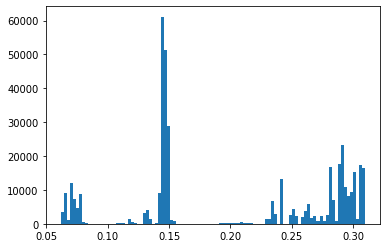

In [16]:
plt.hist(predicted_scores[:,1],bins=100)
plt.show()

## Métricas de desempeño

### ROC y AUC

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, predicted_scores[:,1], pos_label=1)

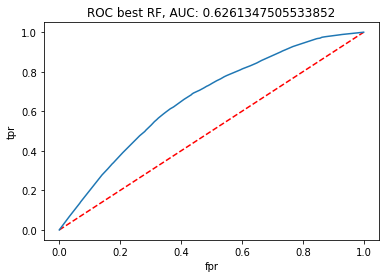

In [18]:
curva_roc(y_test,predicted_labels,fpr,tpr)

### Matriz de confusión

In [19]:
confu0=confusion_matrix(y_test, predicted_labels, normalize='all')
confu1=confusion_matrix(y_test, predicted_labels)

In [20]:
print(tabla_referencia())

Dato\Predicción    Etiqueta +           Etiqueta -
-----------------  -------------------  -------------------
Etiqueta +         True Positive (tp)   False Negative (fn)
Etiqueta -         False Positive (fp)  True Negative (tn)


In [21]:
print(tabla_confusion(confu0))

Dato\Predicción      Etiqueta +    Etiqueta -
-----------------  ------------  ------------
Etiqueta +            0.445988       0.349815
Etiqueta -            0.0629245      0.141273


In [22]:
print(tabla_confusion(confu1))

Dato\Predicción      Etiqueta +    Etiqueta -
-----------------  ------------  ------------
Etiqueta +               185059        145153
Etiqueta -                26110         58620


#### Accuracy

$$accuracy=\frac{\text{tp+tn}}{\text{tp+fp+tn+fn}}= \frac{\text{predichos correctamente}}{\text{total}}$$

#### Precision


$$precision=\frac{\text{tp}}{\text{tp+fp}}= \frac{\text{predichos positivos correctos}}{\text{predichos positivos}}$$

De los que identificamos como clase positiva, cuántos identificamos correctamente -pureza en nuestra predicción-. 

### Recall

$$recall=\frac{\text{tp}}{\text{tp+fn}}= \frac{\text{predichos positivos correctos}}{\text{datos positivos}}$$

Del universo posible de nuestra clase positiva, cúantos identificamos correctamente

#### F1-score

Combina precision y recall para obtimizar ambos.

$$F=2\cdot  \left( \frac{\text{precision}\cdot \text{recall}}{\text{precision + recall}} \right)$$

In [23]:
#### Accuracy
accuracy_score(y_test, predicted_labels)

0.5872603881988326

In [24]:
#### Precision, recall, thresholds
precision, recall, thresholds_2 = precision_recall_curve(y_test, predicted_scores[:,1], pos_label=1)

In [25]:
thresholds_2 = np.append(thresholds_2, 1)

In [26]:
(precision.shape, recall.shape, thresholds_2.shape)

((961,), (961,), (961,))

In [27]:
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
metrics_report

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
0,0.061789,0.204230,1.000000,0.339187,1.000000,0.999800,0.000200,0.000000
1,0.062372,0.204316,0.999953,0.339303,0.999953,0.999225,0.000775,0.000047
2,0.062452,0.204323,0.999941,0.339313,0.999941,0.999167,0.000833,0.000059
3,0.062490,0.204425,0.999823,0.339447,0.999823,0.998422,0.001578,0.000177
4,0.062552,0.204458,0.999799,0.339490,0.999799,0.998198,0.001802,0.000201
...,...,...,...,...,...,...,...,...
935,0.303305,0.341528,0.142323,0.200918,0.142323,0.070409,0.929591,0.857677
936,0.305946,0.340072,0.135607,0.193896,0.135607,0.067523,0.932477,0.864393
937,0.306196,0.339078,0.128172,0.186026,0.128172,0.064104,0.935896,0.871828
938,0.308563,0.345293,0.066671,0.111762,0.066671,0.032437,0.967563,0.933329


In [28]:
metrics_report[(metrics_report.loc[:,'threshold']<= 0.19) & (metrics_report.loc[:,'threshold'] >= 0.17)]

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
679,0.170365,0.287602,0.691915,0.406315,0.691915,0.439772,0.560228,0.308085
680,0.170615,0.287607,0.691915,0.406319,0.691915,0.439763,0.560237,0.308085
681,0.174070,0.287626,0.691904,0.406336,0.691904,0.439714,0.560286,0.308096
682,0.175823,0.287627,0.691904,0.406338,0.691904,0.439711,0.560289,0.308096
683,0.176524,0.287657,0.691904,0.406367,0.691904,0.439648,0.560352,0.308096
684,0.177163,0.287657,0.691880,0.406363,0.691880,0.439633,0.560367,0.308120
685,0.177865,0.287662,0.691868,0.406366,0.691868,0.439615,0.560385,0.308132
686,0.178834,0.287658,0.691856,0.406361,0.691856,0.439615,0.560385,0.308144
687,0.180174,0.287673,0.691845,0.406374,0.691845,0.439575,0.560425,0.308155
688,0.180923,0.287674,0.691833,0.406372,0.691833,0.439566,0.560434,0.308167


In [35]:
negocio = metrics_report[metrics_report.fpr <= 0.06]
negocio

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
938,0.308563,0.345293,0.066671,0.111762,0.066671,0.032437,0.967563,0.933329
939,0.309855,0.345156,0.059377,0.101323,0.059377,0.028906,0.971094,0.940623


In [36]:
punto_corte = negocio.head(1).threshold.values[0]
punto_corte

0.308562718472398

In [37]:
new_labels = [0 if score < punto_corte else 1 for score in predicted_scores[:,1]]


In [38]:
new_labels[:10]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

In [39]:
pd.Series(new_labels).sum()

16360

In [40]:
print(tabla_confusion(confusion_matrix(y_test, new_labels)))

Dato\Predicción      Etiqueta +    Etiqueta -
-----------------  ------------  ------------
Etiqueta +               319501         10711
Etiqueta -                79081          5649


In [41]:
print(tabla_confusion(confusion_matrix(y_test, predicted_labels)))

Dato\Predicción      Etiqueta +    Etiqueta -
-----------------  ------------  ------------
Etiqueta +               185059        145153
Etiqueta -                26110         58620


In [56]:
precision_at_k(y_test,new_labels,0.04)

0.20419721310448208

In [57]:
recall_at_k(y_test,new_labels,0.04)

1.0

In [51]:
precision_at_k(new_labels,y_test,0.04)

0.0666706007317361

In [58]:
recall_at_k(new_labels,y_test,0.04)

0.34529339853300733

In [60]:
recall_at_k(y_test,predicted_scores[:,1],0.04)

0.12817183996223297

In [61]:
precision_at_k(y_test,predicted_scores[:,1],0.04)

0.3390783064818284

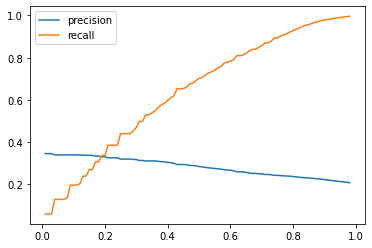

In [62]:
curva_pre_re(y_test, predicted_scores[:,1])

## Aequitas